In [1]:
pip install torch torchvision pycocotools matplotlib


In [2]:
import torch
from torchvision.models.detection import ssd300_vgg16
from torchvision.transforms import functional as F
import numpy as np

# Load the pre-trained SSD model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ssd_model = ssd300_vgg16(pretrained=True).to(device)
ssd_model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:02<00:00, 63.9MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

def preprocess_image(image):
    # Transform the image for SSD input
    return F.to_tensor(image).unsqueeze(0).to(device)


In [4]:
def get_ssd_predictions(image, model, confidence_threshold=0.5):
    with torch.no_grad():
        # Get predictions
        outputs = model(image)
    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    labels = outputs[0]['labels'].cpu().numpy()

    # Filter predictions based on confidence threshold
    filtered_indices = scores > confidence_threshold
    boxes = boxes[filtered_indices]
    scores = scores[filtered_indices]
    labels = labels[filtered_indices]

    return boxes, scores, labels


In [5]:
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [18]:
def apply_action(box, action):
    # Example action: Refine bounding box [x_min, y_min, x_max, y_max]
    dx, dy, dw, dh = action  # Make sure `action` is a list/tuple of four values
    x_min, y_min, x_max, y_max = box
    return [x_min + dx, y_min + dy, x_max + dw, y_max + dh]



In [19]:
def refine_boxes_with_dqn(boxes, dqn_model):
    refined_boxes = []
    for box in boxes:
        # Example: Use DQN model to predict an action
        # Replace `predict_action` with your DQN inference code
        action = predict_action(box, dqn_model)  # Should return [dx, dy, dw, dh]

        if not isinstance(action, (list, tuple)) or len(action) != 4:
            raise ValueError("Action must be a list or tuple of four values [dx, dy, dw, dh]")

        refined_box = apply_action(box, action)
        refined_boxes.append(refined_box)
    return refined_boxes


In [20]:
def predict_action(box, dqn_model):
    # Example: Convert box to feature vector and pass through DQN
    input_features = torch.tensor(box, dtype=torch.float32).unsqueeze(0).to(device)
    action_values = dqn_model(input_features)

    # Convert DQN output to an action (e.g., argmax or direct values)
    action = action_values.squeeze().tolist()  # Ensure it returns a list/tuple of four values
    return action


In [21]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union


In [22]:
def evaluate_predictions(ground_truth_boxes, predicted_boxes, iou_threshold=0.5):
    correct = 0
    total = len(predicted_boxes)

    for pred_box in predicted_boxes:
        for gt_box in ground_truth_boxes:
            iou = compute_iou(pred_box, gt_box)
            if iou >= iou_threshold:
                correct += 1
                break  # Avoid double-counting

    precision = correct / total if total > 0 else 0
    return precision


In [23]:
import os

image_path = "C:/Users/dnave/Downloads/COCO Dataset/coco2017/val2017/000000580294.jpg"
if os.path.exists(image_path):
    print("File exists")
else:
    print("File not found")


File not found


In [24]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
image_path = "/content/drive/My Drive/COCOSampleImage.jpg"


Precision: 0.00%


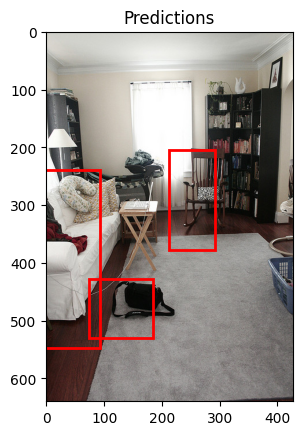

In [26]:
image = load_image(image_path)
processed_image = preprocess_image(image)

# Get SSD predictions
boxes, scores, labels = get_ssd_predictions(processed_image, ssd_model)

# Use DQN to refine predictions
dqn_model = DQN(input_dim=4, action_dim=4).to(device)  # Example: 4 input features, 4 actions
refined_boxes = refine_boxes_with_dqn(boxes, dqn_model)

# Ground truth (for evaluation, replace with real ground truth)
ground_truth_boxes = [[50, 50, 200, 200], [30, 30, 100, 100]]  # Example boxes

# Evaluate predictions
precision = evaluate_predictions(ground_truth_boxes, refined_boxes)
print(f"Precision: {precision * 100:.2f}%")

# Visualize results
def visualize(image, boxes, title="Predictions"):
    plt.imshow(image)
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='red', facecolor='none', linewidth=2))
    plt.title(title)
    plt.show()

visualize(image, refined_boxes)
